In [1]:
!pip install keras==2.2.4
!pip install tensorflow-gpu==1.14.0
!pip install pandas_ml
!conda install pandas==0.24.2

Solving environment: done

# All requested packages already installed.



In [3]:
import numpy as np
from keras import layers, models, optimizers
from keras import backend as K
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from utils import combine_images
from pandas_ml import ConfusionMatrix
from PIL import Image
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask
import seaborn as sns
import pandas as pd

sns.set()

#importint the necessary lirbraries

#import tensorflow.keras as kerasfrom __future__ import print_function

import keras
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



import tensorflow as tf
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from keras.optimizers import Adam, SGD
from keras import optimizers
from keras.layers import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from os import listdir
import os
from imutils import paths
import numpy as np
import pickle
import matplotlib.pyplot as plt
import cv2
import random

K.set_image_data_format('channels_last')

Using TensorFlow backend.
/home/michael/anaconda3/envs/tensorlow-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/michael/anaconda3/envs/tensorlow-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/michael/anaconda3/envs/tensorlow-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [4]:
def CapsNet(input_shape, n_class, routings):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 3d, [width, height, channels]
    :param n_class: number of classes
    :param routings: number of routing iterations
    :return: Two Keras Models, the first one used for training, and the second one for evaluation.
            `eval_model` can also be used for training.
    """
    x = layers.Input(shape=input_shape)

    # Layer 1: Just a conventional Conv2D layer
    conv1 = layers.Conv2D(filters=128, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
    primarycaps = PrimaryCap(conv1, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
                             name='digitcaps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    # If using tensorflow, this will not be necessary. :)
    out_caps = Length(name='capsnet')(digitcaps)

    # Decoder network.
    y = layers.Input(shape=(n_class,))
    masked_by_y = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer. For training
    masked = Mask()(digitcaps)  # Mask using the capsule with maximal length. For prediction

    # Shared Decoder model in training and prediction
    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(512, activation='relu', input_dim=16*n_class))
    decoder.add(layers.Dense(1024, activation='relu'))
    decoder.add(layers.Dense(np.prod(input_shape), activation='sigmoid'))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # Models for training and evaluation (prediction)
    train_model = models.Model([x, y], [out_caps, decoder(masked_by_y)])
    eval_model = models.Model(x, [out_caps, decoder(masked)])

    # manipulate model
    noise = layers.Input(shape=(n_class, 16))
    noised_digitcaps = layers.Add()([digitcaps, noise])
    masked_noised_y = Mask()([noised_digitcaps, y])
    manipulate_model = models.Model([x, y, noise], decoder(masked_noised_y))
    return train_model, eval_model, manipulate_model


def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

In [5]:
#define the model
model, eval_model, manipulate_model = CapsNet(input_shape=(28, 28, 3),
                                                  n_class=10,
                                                  routings=3)
model.summary()




Instructions for updating:
dim is deprecated, use axis instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 20, 20, 128)  31232       input_1[0][0]                    
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (None, 6, 6, 256)    2654464     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 1152, 8)      0           primarycap_conv2d[0][0]          
___________________________________________

In [9]:
#Now rewriting the algorithm to preprocess about 500 images in my own pipeline
#only do this if you have enough RAM
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            image = cv2.resize(image, (28, 28))
            return img_to_array(image)
        else:
            return np.array([])
        
    except Exception as e:
        print(f"Error : {e}")
        return None

image_list = []

directory_root = '../dataset/train'
imagePaths = list(paths.list_images(directory_root))
imagePaths = imagePaths[0:-1:2]
random.shuffle(imagePaths)
labels = [p.split(os.path.sep)[-2] for p in imagePaths]

batch_size = 16
try:
    for i in np.arange(0, len(imagePaths), batch_size):
        batchPaths = imagePaths[i:i + batch_size]
        batchLabels = labels[i: i + batch_size]
        
        for image in batchPaths:
            image_list.append(convert_image_to_array(image))
except Exception as e:
    print(f"Error: {e}")


len(image_list), len(labels)

np_image_list = np.array(image_list, dtype = np.float16) / 255.0
print(f"[INFO] splitting data")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, labels, test_size = 0.2, random_state = 42)

[INFO] splitting data


In [10]:
np_image_list.shape

(9080, 28, 28, 3)

In [11]:
y_test_unclassfied = y_test.copy()

In [11]:
y_test = LabelBinarizer().fit_transform(y_test)
y_train = LabelBinarizer().fit_transform(y_train)

In [12]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
x_train.shape, x_test.shape

((7264, 28, 28, 3), (1816, 28, 28, 3))

In [13]:
x_train = x_train.reshape((x_train.shape[0], 28, 28, 3))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 3))
x_train.shape, x_test.shape

((7264, 28, 28, 3), (1816, 28, 28, 3))

In [9]:
y_test.shape

(1816, 10)

In [10]:
x_train.shape, len(y_test)
classNames = [str(x) for x in np.unique(labels)]

In [11]:
#fitting the model
model.compile(optimizer=optimizers.Adam(lr=0.001),
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., 0.392],
                  metrics={'capsnet': 'accuracy'})

weight_path = '../models/best_weights_capsule_train.h5'
checkpoint = ModelCheckpoint(weight_path, monitor='val_capsnet_acc',
                                           save_best_only=True, save_weights_only=True, verbose=1)
history = model.fit([x_train, y_train], [y_train, x_train], validation_data = [[x_test, y_test], [y_test, x_test]], epochs = 100, batch_size = 16, callbacks=[checkpoint])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7264 samples, validate on 1816 samples
Epoch 1/100
7264/7264 [==============================] - 188s 26ms/step - loss: 0.4657 - capsnet_loss: 0.4557 - decoder_loss: 0.0256 - capsnet_acc: 0.3703 - val_loss: 0.3524 - val_capsnet_loss: 0.3430 - val_decoder_loss: 0.0238 - val_capsnet_acc: 0.4917

Epoch 00001: val_capsnet_acc improved from -inf to 0.49174, saving model to ../models/best_weights_capsule_train.h5
Epoch 2/100
7264/7264 [==============================] - 181s 25ms/step - loss: 0.3037 - capsnet_loss: 0.2947 - decoder_loss: 0.0229 - capsnet_acc: 0.6090 - val_loss: 0.2696 - val_capsnet_loss: 0.2609 - val_decoder_loss: 0.0220 - val_capsnet_acc: 0.6443

Epoch 00002: val_capsnet_acc improved from 0.49174 to 0.64427, saving model to ../models/best_weights_capsule_train.h5
Epoch 3/100
7264/7264 [==============================] - 172s 24ms/step - loss: 0.2493 - capsnet_loss: 0.2409 

KeyboardInterrupt: 

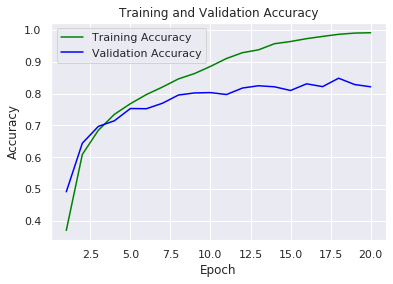

<Figure size 432x288 with 0 Axes>

In [13]:
acc = model.history.history['capsnet_acc']
val_acc = model.history.history['val_capsnet_acc']
loss = model.history.history['capsnet_loss']
val_loss = model.history.history['val_capsnet_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('./Plots/Accuracy_Capsulenet_Colored.png')
plt.show()
plt.clf()

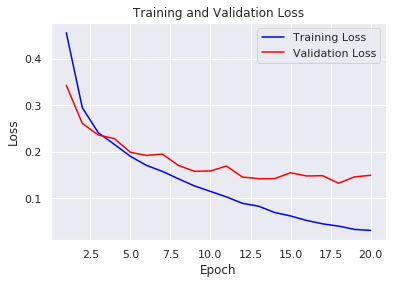

In [16]:
#loss plot
plt.plot(epochs, loss, color='blue', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./Plots/Loss_Capsulenet_Colored.png')
plt.show()


In [12]:
#import the weights from saved
eval_model.load_weights("../models/best_weights_capsule_new_train.h5")
y_pred = []
for i in range(0, x_test.shape[0]):
    img = np.expand_dims(x_test[i], axis=0)
    prediction, y_recon = eval_model.predict(img)
    li = ["Bacterial_spot", "Early_blight","healthy", "Late_blight", "Leaf_Mold", "mosaic_virus", "Septoria_leaf_spot", "spider_mite","Target_Spot","Yellow_Leaf_Curl"] 
    class_name = li[prediction.argmax()]
    y_pred.append(class_name)

In [13]:
len(y_test_unclassfied) == len(y_pred)

True

In [14]:
#plotting the confusion matrix and evaluating the predictions
confusion_matrix = ConfusionMatrix(y_test_unclassfied, y_pred)
print("Confusion matrix:\n%s" % confusion_matrix)

Confusion matrix:
Predicted           Bacterial_spot  Early_blight  Late_blight  Leaf_Mold  \
Actual                                                                     
Bacterial_spot                 181             1            0          3   
Early_blight                    10            71            0          4   
Late_blight                      4             4            1          1   
Leaf_Mold                        2             0           86         18   
Septoria_leaf_spot               3             1            4        157   
Target_Spot                      4             2            0          4   
Yellow_Leaf_Curl                 9             0            0          1   
healthy                          0             0            0          0   
mosaic_virus                     0             0            3          6   
spider_mite                      1             0            1          0   
__all__                        214            79           95        1

In [15]:
confusion_matrix.print_stats()

/home/michael/anaconda3/envs/tensorlow-gpu/lib/python3.7/site-packages/pandas_ml/confusion_matrix/stats.py:60: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  num = df[df > 1].dropna(axis=[0, 1], thresh=1).applymap(lambda n: choose(n, 2)).sum().sum() - np.float64(nis2 * njs2) / n2


Confusion Matrix:

Predicted           Bacterial_spot  Early_blight  Late_blight  Leaf_Mold  \
Actual                                                                     
Bacterial_spot                 181             1            0          3   
Early_blight                    10            71            0          4   
Late_blight                      4             4            1          1   
Leaf_Mold                        2             0           86         18   
Septoria_leaf_spot               3             1            4        157   
Target_Spot                      4             2            0          4   
Yellow_Leaf_Curl                 9             0            0          1   
healthy                          0             0            0          0   
mosaic_virus                     0             0            3          6   
spider_mite                      1             0            1          0   
__all__                        214            79           95        

In [16]:
confusion_matrix.to_dataframe().to_csv("./Results/confusion_matrix_colored.csv")
confusion_matrix.to_dataframe()

Predicted,Bacterial_spot,Early_blight,Late_blight,Leaf_Mold,Septoria_leaf_spot,Target_Spot,Yellow_Leaf_Curl,healthy,mosaic_virus,spider_mite
Actual,,,,,,,,,,
Bacterial_spot,181,1,0,3,9,0,1,3,0,2
Early_blight,10,71,0,4,4,0,0,5,6,2
Late_blight,4,4,1,1,2,1,2,150,4,3
Leaf_Mold,2,0,86,18,1,1,1,2,0,0
Septoria_leaf_spot,3,1,4,157,5,3,3,3,6,0
Target_Spot,4,2,0,4,2,1,11,0,118,9
Yellow_Leaf_Curl,9,0,0,1,512,0,3,0,4,0
healthy,0,0,0,0,0,0,2,1,4,154
mosaic_virus,0,0,3,6,1,27,2,0,1,0


In [14]:
confusion_matrix.stats_overall

OrderedDict([('Accuracy', 0.17015418502202642),
             ('95% CI', (0.15313970056026627, 0.18824124883536253)),
             ('No Information Rate', 'ToDo'),
             ('P-Value [Acc > NIR]', 0.9999999999999999),
             ('Kappa', 0.07430898197435461),
             ("Mcnemar's Test P-Value", 'ToDo')])

In [15]:
confusion_matrix.stats_class.to_csv("./Results/confusion_matrix_report.csv")
confusion_matrix.stats_class

Classes,Bacterial_spot,Early_blight,Late_blight,Leaf_Mold,Septoria_leaf_spot,Target_Spot,Yellow_Leaf_Curl,healthy,mosaic_virus,spider_mite
Population,1816,1816,1816,1816,1816,1816,1816,1816,1816,1816
P: Condition positive,239,96,187,102,169,139,529,170,33,152
N: Condition negative,1577,1720,1629,1714,1647,1677,1287,1646,1783,1664
Test outcome positive,249,74,84,183,544,26,155,184,139,178
Test outcome negative,1567,1742,1732,1633,1272,1790,1661,1632,1677,1638
TP: True Positive,218,61,0,14,8,1,4,1,1,1
TN: True Negative,1546,1707,1545,1545,1111,1652,1136,1463,1645,1487
FP: False Positive,31,13,84,169,536,25,151,183,138,177
FN: False Negative,21,35,187,88,161,138,525,169,32,151
"TPR: (Sensitivity, hit rate, recall)",0.912134,0.635417,0,0.137255,0.0473373,0.00719424,0.00756144,0.00588235,0.030303,0.00657895


# Metrics and Accuracy for each of the Classes in the Dataset

## 	Bacterial_spot
#### True Positive Rate(Sensitivity) - 0.912134
#### True Negative Rate(Specificity) - 0.980342
#### Accuracy - 0.971366		

## 	Early_blight
#### True Positive Rate(Sensitivity) - 0.635417	
#### True Negative Rate(Specificity) - 0.992442
#### Accuracy - 0.973568		

## 	Late_blight
#### True Positive Rate(Sensitivity) - 0
#### True Negative Rate(Specificity) - 0.948435	
#### Accuracy - 0.850771		

## 	Leaf_Mold
#### True Positive Rate(Sensitivity) - 0.137255	
#### True Negative Rate(Specificity) - 0.9014	
#### Accuracy - 0.85848		

## 	Septoria_leaf_spot
#### True Positive Rate(Sensitivity) - 0.0473373	
#### True Negative Rate(Specificity) - 0.67456	
#### Accuracy - 0.616189

## 	Target_spot
#### True Positive Rate(Sensitivity) - 	0.00719424
#### True Negative Rate(Specificity) - 0.985092	
#### Accuracy - 0.910242		

## 	Yellow_Leaf_Curl	
#### True Positive Rate(Sensitivity) - 0.00756144
#### True Negative Rate(Specificity) - 0.882673
#### Accuracy - 0.627753		

## 	Healthy
#### True Positive Rate(Sensitivity) - 	0.00588235	
#### True Negative Rate(Specificity) - 0.888821
#### Accuracy - 0.806167

## 	Mosaic virus
#### True Positive Rate(Sensitivity) - 0.030303
#### True Negative Rate(Specificity) - 0.922602
#### Accuracy - 0.906388	

## 	Spider mite
#### True Positive Rate(Sensitivity) - 0.00657895
#### True Negative Rate(Specificity) - 0.89363
#### Accuracy - 0.819383


## Other statistics
#### Kappa Statistics - 0.07430898197435461
#### P-Value - 0.9999999999999999
#### Overall accuracy -  0.17015418502202642
